#Import libs

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np
import random
import scipy

random.seed(42)
np.random.seed(42)
sns.set(style='ticks', color_codes=True)

train_path = 'drive/MyDrive/Dataset/churn/2019/churn-bigml-80.csv'
test_path = 'drive/MyDrive/Dataset/churn/2019/churn-bigml-20.csv'
# y_test_path = 'drive/MyDrive/Dataset/churn/sampleSubmission.csv'

In [ ]:
df = pd.read_csv(train_path)

In [ ]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [ ]:
df.drop(['State', 'Area code'], axis=1, inplace=True)

In [ ]:
df.corr()

,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
Account length,1.000000,-0.002996,0.002847,0.038862,0.002843,-0.015923,0.018552,-0.015909,-0.008994,-0.024007,-0.008999,0.011369,0.017627,0.011383,0.002455,0.017728
Number vmail messages,-0.002996,1.000000,0.019027,-0.009622,0.019027,0.011401,0.005131,0.011418,-0.000224,0.008124,-0.000229,-0.004156,0.027013,-0.004136,-0.018787,-0.086474
Total day minutes,0.002847,0.019027,1.000000,0.016780,1.000000,0.003999,0.009059,0.003992,0.013491,0.015054,0.013464,-0.011042,0.005687,-0.010934,-0.024543,0.195688
Total day calls,0.038862,-0.009622,0.016780,1.000000,0.016787,-0.026003,0.006473,-0.026006,0.008986,-0.016776,0.008972,0.031036,0.006928,0.031133,-0.011945,0.018290
Total day charge,0.002843,0.019027,1.000000,0.016787,1.000000,0.004008,0.009056,0.004002,0.013495,0.015057,0.013468,-0.011046,0.005688,-0.010938,-0.024548,0.195689
Total eve minutes,-0.015923,0.011401,0.003999,-0.026003,0.004008,1.000000,-0.007654,1.000000,-0.013414,0.009017,-0.013450,-0.006915,0.002160,-0.006947,-0.013192,0.072906
Total eve calls,0.018552,0.005131,0.009059,0.006473,0.009056,-0.007654,1.000000,-0.007642,-0.000175,0.000797,-0.000135,0.011012,0.003710,0.011000,0.001058,-0.001539
Total eve charge,-0.015909,0.011418,0.003992,-0.026006,0.004002,1.000000,-0.007642,1.000000,-0.013428,0.009030,-0.013464,-0.006923,0.002169,-0.006955,-0.013196,0.072893
Total night minutes,-0.008994,-0.000224,0.013491,0.008986,0.013495,-0.013414,-0.000175,-0.013428,1.000000,0.012736,0.999999,-0.008607,-0.001110,-0.008510,0.005236,0.033639
Total night calls,-0.024007,0.008124,0.015054,-0.016776,0.015057,0.009017,0.000797,0.009030,0.012736,1.000000,0.012720,-0.023447,0.019367,-0.023434,-0.005677,0.012262


Text(0.5, 1.0, 'Correlation Heatmap')

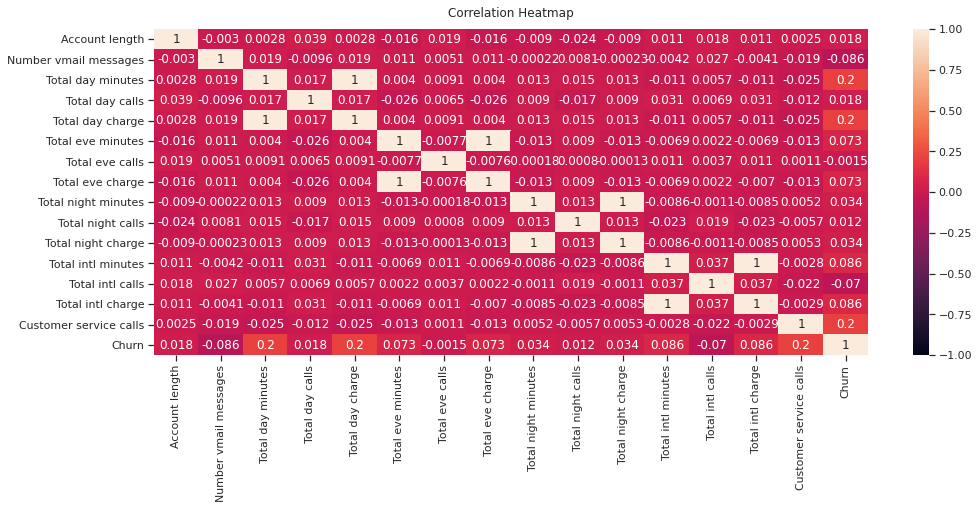

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(),
                      vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap',
                  fontdict={'fontsize':12}, pad=12)

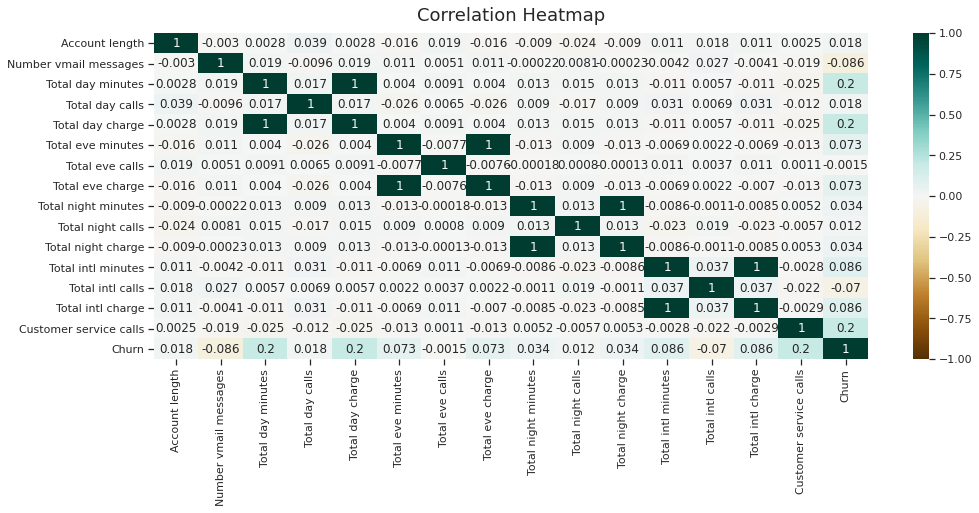

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(),
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap',
                  fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmap.png', dpi=600, bbox_inches='tight')

In [ ]:
df.drop(['Total day minutes', 
         'Total night minutes', 
         'Total intl minutes', 
         'Total eve minutes'], axis=1, inplace=True)

In [ ]:
df.head()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day calls,Total day charge,Total eve calls,Total eve charge,Total night calls,Total night charge,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,No,Yes,25,110,45.07,99,16.78,91,11.01,3,2.70,1,False
1,107,No,Yes,26,123,27.47,103,16.62,103,11.45,3,3.70,1,False
2,137,No,No,0,114,41.38,110,10.30,104,7.32,5,3.29,0,False
3,84,Yes,No,0,71,50.90,88,5.26,89,8.86,7,1.78,2,False
4,75,Yes,No,0,113,28.34,122,12.61,121,8.41,3,2.73,3,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          2666 non-null   int64  
 1   International plan      2666 non-null   object 
 2   Voice mail plan         2666 non-null   object 
 3   Number vmail messages   2666 non-null   int64  
 4   Total day calls         2666 non-null   int64  
 5   Total day charge        2666 non-null   float64
 6   Total eve calls         2666 non-null   int64  
 7   Total eve charge        2666 non-null   float64
 8   Total night calls       2666 non-null   int64  
 9   Total night charge      2666 non-null   float64
 10  Total intl calls        2666 non-null   int64  
 11  Total intl charge       2666 non-null   float64
 12  Customer service calls  2666 non-null   int64  
 13  Churn                   2666 non-null   bool   
dtypes: bool(1), float64(4), int64(7), object

#Functions

## Train test split

In [ ]:
def get_train_test(df):
    df_X = df.drop('Churn',axis=1)
    df_y = df['Churn']
    df_X['International plan'] = np.where(df_X['International plan'].str.contains('yes'), 1, 0)
    df_X['Voice mail plan'] = np.where(df_X['Voice mail plan'].str.contains('yes'), 1, 0)
    X = df_X
    y = np.asarray([0 if x == False else 1 for x in df_y])
    print('X train shape=', X.shape)
    print('y train shape=', y.shape)
    print('Churn in train rate:', np.sum(y==1)/len(y))
    # X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
    #                                                     test_size=0.1,
    #                                                     random_state=42)
    return X.values, y


In [ ]:
def get_val_data(test_path=test_path):
    df = pd.read_csv(test_path)
    y = df['Churn'].values.copy()
    df.drop(['Churn'], axis=1, inplace=True )
    df.drop(['State', 'Area code'], axis=1, inplace=True)
    df.drop(['Total day minutes', 
             'Total night minutes', 
             'Total intl minutes', 
             'Total eve minutes'], axis=1, inplace=True)
    X = df
    # y = df_y['Churn'].copy()
    X['International plan'] = np.where(X['International plan'].str.contains('yes'), 1, 0)
    X['Voice mail plan'] = np.where(X['Voice mail plan'].str.contains('yes'), 1, 0)

    y = np.asarray([0 if x == False else 1 for x in y])

    print(" X val shape = ", X.shape)
    print(" y val shape = ", y.shape)
    print('Churn in train rate:', np.sum(y==1)/len(y))
    return X.values, y 

##Resampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
def resampling(X_train, y_train):
    oversample = SMOTE()
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    return X_train, y_train

## Model tunning

In [ ]:
def search_for_best_models(clf, params, X_train, y_train, scoring='accuracy'):
    optimal_models = RandomizedSearchCV(clf,
                            param_distributions=params,
                            cv=3,
                            n_jobs=4,
                            random_state=42,
                            scoring=scoring)
    optimal_models.fit(X_train, y_train)

    return (optimal_models.best_params_,
            optimal_models.best_estimator_)


# Getting Data

In [ ]:
X_train, y_train = get_train_test(df)
X_val, y_val = get_val_data()

X train shape= (2666, 13)
y train shape= (2666,)
Churn in train rate: 0.145536384096024
 X val shape =  (667, 13)
 y val shape =  (667,)
Churn in train rate: 0.1424287856071964


In [ ]:
X_train_resampled, y_train_resampled = resampling(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#Outlier detection

In [ ]:
from sklearn.svm import OneClassSVM
oneClassSVM = OneClassSVM(gamma='scale', nu=0.14)

In [ ]:
trainX = X_train[y_train == 0]

In [ ]:
oneClassSVM.fit(trainX)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.14, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_preds = oneClassSVM.predict(X_val)

In [ ]:
y_preds[:10]

array([ 1,  1, -1,  1,  1, -1,  1,  1, -1, -1])

In [ ]:
y_val[:10]

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
valy = y_val.copy()

In [ ]:
valy[valy == 1] = -1
valy[valy == 0] = 1

In [ ]:
print(metrics.confusion_matrix(valy, y_preds))

[[ 13  82]
 [ 94 478]]


In [ ]:
valy[:10]

array([ 1, -1, -1,  1,  1,  1,  1, -1,  1,  1])

In [ ]:
print(metrics.classification_report(valy, y_preds))

              precision    recall  f1-score   support

          -1       0.12      0.14      0.13        95
           1       0.85      0.84      0.84       572

    accuracy                           0.74       667
   macro avg       0.49      0.49      0.49       667
weighted avg       0.75      0.74      0.74       667



In [ ]:
from sklearn.ensemble import IsolationForest
isolationForest = IsolationForest(bootstrap=True,
                                  n_jobs=4,
                                  n_estimators=1000)

In [ ]:
isolationForest.fit(trainX)

IsolationForest(behaviour='deprecated', bootstrap=True, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=1000,
                n_jobs=4, random_state=None, verbose=0, warm_start=False)

In [ ]:
y_preds = isolationForest.predict(X_val)

In [ ]:
valy = y_val.copy()

In [ ]:
valy[valy == 1] = -1
valy[valy == 0] = 1

In [ ]:
print(metrics.confusion_matrix(valy, y_preds))

[[ 17  78]
 [ 69 503]]


In [ ]:
print(metrics.classification_report(valy, y_preds))

              precision    recall  f1-score   support

          -1       0.20      0.18      0.19        95
           1       0.87      0.88      0.87       572

    accuracy                           0.78       667
   macro avg       0.53      0.53      0.53       667
weighted avg       0.77      0.78      0.77       667



# Models

## KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)

In [ ]:
neigh.fit(X_train,
          y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
y_preds = neigh.predict(X_val)

In [ ]:
print(metrics.classification_report(y_preds, y_val))

              precision    recall  f1-score   support

           0       0.96      0.88      0.91       625
           1       0.18      0.40      0.25        42

    accuracy                           0.85       667
   macro avg       0.57      0.64      0.58       667
weighted avg       0.91      0.85      0.87       667



##SVM

In [ ]:
svm_params = {'C': scipy.stats.expon(scale=1.), 
          'gamma': scipy.stats.expon(scale=.1),
          'kernel': ['rbf'], 
          'class_weight':[None]}

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
optimal_params, optimal_models = search_for_best_models(SVC(), svm_params,
                                                        X_train_scaled,
                                                        y_train_resampled)

In [ ]:
svc = SVC(C=optimal_params['C'],
          gamma=optimal_params['gamma'],
          kernel=optimal_params['kernel'],
          class_weight=optimal_params['class_weight'],
          random_state=42)
svc.fit(X_train_scaled, y_train_resampled)

SVC(C=0.4692680899768591, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.3010121430917521, kernel='rbf', max_iter=-1, probability=False,
    random_state=42, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_val_preds = svc.predict(X_val_scaled)

In [ ]:
print(metrics.classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       572
           1       0.42      0.43      0.43        95

    accuracy                           0.84       667
   macro avg       0.66      0.67      0.67       667
weighted avg       0.84      0.84      0.84       667



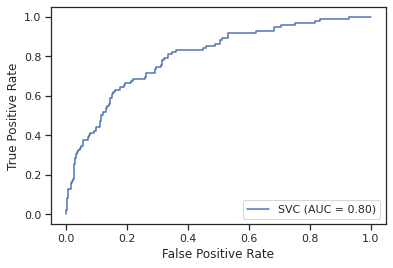

In [ ]:
metrics.plot_roc_curve(svc, X_val_scaled, y_val)

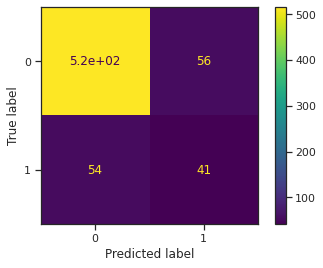

In [ ]:
metrics.plot_confusion_matrix(svc, X_val_scaled, y_val)

##XGBoost

In [ ]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(4556, 13)
(4556,)


In [ ]:
param_grid = {
     'max_depth': [2, 4, 5, 8],
     'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.],
     'gamma': [0.01, 0.1, 0.25, 0.5],
     'reg_lambda': [10.0, 20., 50., 100.],
      'scale_pos_weight': [1]}

In [ ]:
optimal_params = RandomizedSearchCV(
    estimator=XGBClassifier(objective='binary:logistic', 
    seed=42, subsample=0.9,
    colsample_bytree=0.5),
    param_distributions=param_grid,
    scoring='accuracy',
    n_jobs=4, cv=3)

In [ ]:
optimal_params.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.5, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1,...
                                           seed=42, silent=None, subsample=0.9,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
params = optimal_params.best_params_

In [ ]:
clf_xgb = XGBClassifier(objective='binary:logistic',
                        gamma=params['gamma'],
                        learn_rate=params['learning_rate'],
                        max_depth=params['max_depth'],
                        reg_lambda=params['reg_lambda'],
                        scale_pos_weight=1,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        random_state=42,
                        n_jobs=4)


In [ ]:
clf_xgb.fit(X_train_resampled, 
            y_train_resampled, 
            verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25,
              learn_rate=0.5, learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=10.0, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [ ]:
y_val_preds = clf_xgb.predict(X_val)

In [ ]:
print(metrics.classification_report(y_val, 
                                    y_val_preds))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       572
           1       0.76      0.67      0.72        95

    accuracy                           0.92       667
   macro avg       0.85      0.82      0.84       667
weighted avg       0.92      0.92      0.92       667



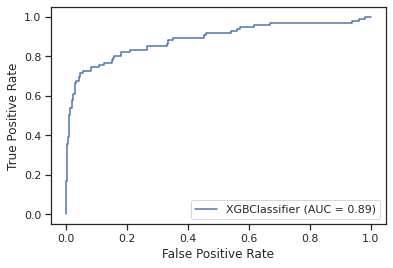

In [ ]:
metrics.plot_roc_curve(clf_xgb, X_val, y_val)

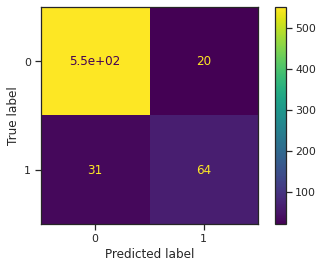

In [ ]:
metrics.plot_confusion_matrix(clf_xgb, X_val, y_val)

## Bagging

In [ ]:
from sklearn.tree import DecisionTreeClassifier
params = {
    'base_estimator': [LogisticRegression(),
                       SVC(), DecisionTreeClassifier()],
    'n_estimators': [10, 20, 50, 100, 200],
    'max_features':[0.3, 0.5, 0,75, 1.],
}

In [ ]:
optimal_params, optimal_models = search_for_best_models(BaggingClassifier(), params,
                       X_train_resampled,
                       y_train_resampled)

In [ ]:
bagging = BaggingClassifier(
    base_estimator=optimal_params['base_estimator'],
    n_estimators=optimal_params['n_estimators'],
    max_features=optimal_params['max_features'],
    random_state=42, n_jobs=4,
    bootstrap_features=True)

In [ ]:
bagging.fit(X_train_resampled, y_train_resampled)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=True, max_features=0.3,
                  max_samples=1.0, n_estimators=200, n_jobs=4, oob_score=False,
                  random_state=42, verb

In [ ]:
y_val_preds = bagging.predict(X_val)

In [ ]:
print(metrics.classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

           0       0.94      0.71      0.81       572
           1       0.30      0.74      0.42        95

    accuracy                           0.71       667
   macro avg       0.62      0.72      0.62       667
weighted avg       0.85      0.71      0.75       667



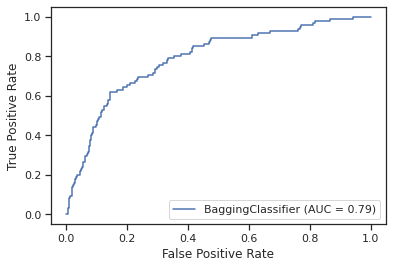

In [ ]:
metrics.plot_roc_curve(bagging, X_val, y_val)

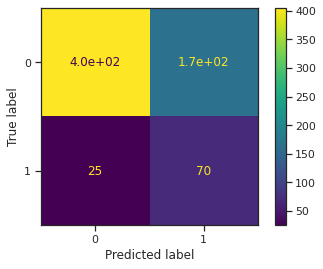

In [ ]:
metrics.plot_confusion_matrix(bagging, X_val, y_val)

## RandomForest

In [ ]:
random.seed(42)
np.random.seed(42)
params = {
    'n_estimators':[10, 50, 100, 200, 500, 1000, 2000],
    'max_features':['auto', 'sqrt', None, 0.5, 0.9],
    'max_depth':[None],
    'min_samples_split': [2]
}

In [ ]:
optimal_params, optimal_models = search_for_best_models(
    clf=RandomForestClassifier(), params=params,
    X_train=X_train_resampled, y_train=y_train_resampled)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
rf = RandomForestClassifier(n_estimators=optimal_params['n_estimators'],
                            max_features=optimal_params['max_features'],
                            max_depth=None,
                            min_samples_split=2,
                            n_jobs=4,
                            random_state=42)

In [ ]:
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=4, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_val_predictions = rf.predict(X_val)
print(metrics.classification_report(y_val, y_val_predictions))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       572
           1       0.73      0.69      0.71        95

    accuracy                           0.92       667
   macro avg       0.84      0.83      0.83       667
weighted avg       0.92      0.92      0.92       667



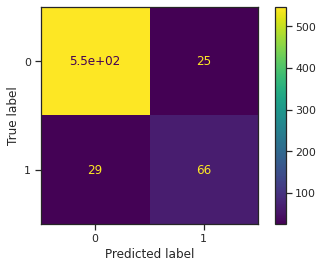

In [ ]:
metrics.plot_confusion_matrix(rf, X_val, y_val)

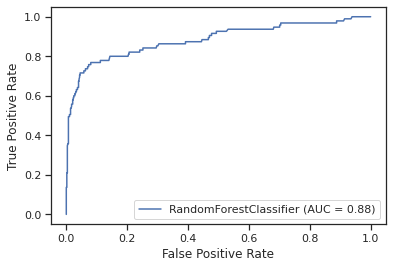

In [ ]:
metrics.plot_roc_curve(rf, X_val, y_val)

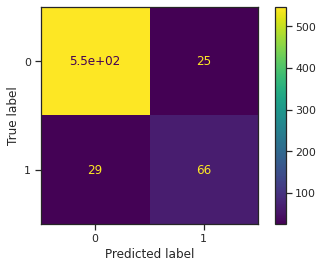

In [ ]:
metrics.plot_confusion_matrix(rf, X_val, y_val)

##Logistic Regression

In [ ]:
params = {"C": np.logspace(-3, 3, 100),
      "penalty": ["l2", 'None'],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
      }

In [ ]:
optimal_params, optimal_models = search_for_best_models(LogisticRegression(),
                                     params,
                                     X_train_resampled,
                                     y_train_resampled)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42, 
                         C=optimal_params['C'],
                         penalty=optimal_params['penalty'],
                         solver=optimal_params['solver'],
                         fit_intercept=True,
                         n_jobs=4)

In [ ]:
clf.fit(X_train_resampled,
        y_train_resampled)

LogisticRegression(C=187.3817422860383, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=4, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_val_preds = clf.predict(X_val)
print(metrics.classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

           0       0.94      0.69      0.80       572
           1       0.29      0.75      0.42        95

    accuracy                           0.70       667
   macro avg       0.62      0.72      0.61       667
weighted avg       0.85      0.70      0.75       667



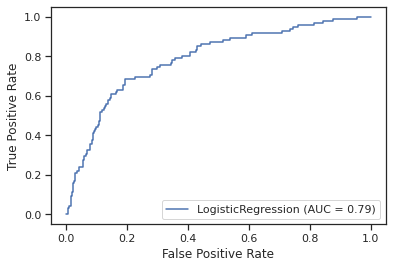

In [ ]:
metrics.plot_roc_curve(clf, X_val, y_val)

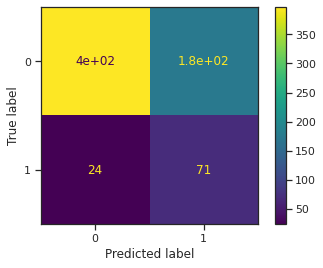

In [ ]:
metrics.plot_confusion_matrix(clf, X_val, y_val)

##Voting

In [ ]:
voting = VotingClassifier(
    estimators=[('rf', 
            RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, 
                       n_estimators=1000,
                       n_jobs=4, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
                 ),
                ('XGBoost', 
                XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25,
              learn_rate=0.5, learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=10.0, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)), 
              ('lg', LogisticRegression(C=187.3817422860383, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=4, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False))
                  ],
                voting='soft',
                weights=[2, 4, 1],
                n_jobs=4
)

In [ ]:
voting.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=0.5,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
           

In [ ]:
y_val_preds = voting.predict(X_val)
print(metrics.classification_report(y_val, y_val_preds))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       572
           1       0.75      0.74      0.74        95

    accuracy                           0.93       667
   macro avg       0.85      0.85      0.85       667
weighted avg       0.93      0.93      0.93       667



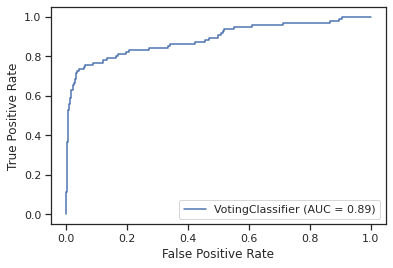

In [ ]:
from sklearn.model_selection import cross_val_score
metrics.plot_roc_curve(voting, X_val, y_val)

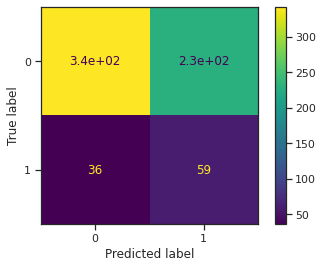

In [ ]:
metrics.plot_confusion_matrix(voting, X_val, y_val)

#Variational Autoencoder

In [ ]:
import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K

In [ ]:
X_train, y_train = get_train_test(df)
X_val, y_val = get_val_data()

X train shape= (2666, 13)
y train shape= (2666,)
Churn in train rate: 0.145536384096024
 X val shape =  (667, 13)
 y val shape =  (667,)
Churn in train rate: 0.1424287856071964


In [ ]:
y_train_non_churn = y_train[y_train==0]
y_train_churn = y_train[y_train==1]

In [ ]:
X_train_non_churn = X_train[y_train==0,:]
X_train_churn = X_train[y_train==1,:]

In [ ]:
# X_test_non_churn = X_test[y_test == 0, :]
# X_test_churn = X_test[y_test == 1, :]

X_val_non_churn = X_val[y_val == 0, :]
X_val_churn = X_val[y_val == 1, :]

# y_test_non_churn = y_test[y_test == 0]
# y_test_churn = y_test[y_test == 1]

y_val_non_churn = y_val[y_val == 0]
y_val_churn = y_val[y_val == 1]

In [ ]:
print("Train churn = ", X_train_churn.shape)
print("Train non churn = ", X_train_non_churn.shape)
# print("Test churn = ", X_test_churn.shape)
# print("Test none churn = ", X_test_non_churn.shape)
print("Val churn = ", X_val_churn.shape)
print("Val none churn = ", X_val_non_churn.shape)

Train churn =  (388, 13)
Train non churn =  (2278, 13)
Val churn =  (95, 13)
Val none churn =  (572, 13)


In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_non_churn = scaler.fit_transform(X_train_non_churn)
X_train_churn = scaler.transform(X_train_churn)

# X_test_non_churn = scaler.transform(X_test_non_churn)
# X_test_churn = scaler.transform(X_test_churn)

X_val_non_churn = scaler.transform(X_val_non_churn)
X_val_churn = scaler.transform(X_val_churn)

In [ ]:
print("Train churn = ", X_train_churn.shape)
print("Train non churn = ", X_train_non_churn.shape)
# print("Test churn = ", X_test_churn.shape)
# print("Test none churn = ", X_test_non_churn.shape)
print("Val churn = ", X_val_churn.shape)
print("Val none churn = ", X_val_non_churn.shape)

Train churn =  (388, 13)
Train non churn =  (2278, 13)
Val churn =  (95, 13)
Val none churn =  (572, 13)


In [ ]:
X_train_reshape = X_train_non_churn
y_train_reshape = y_train_non_churn

original_dim = X_train_reshape.shape[1]
intermediate_dim = 8
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(16, activation='elu')(inputs)
# h = layers.Dense(256, activation='relu')(h)
h = layers.Dense(intermediate_dim, activation='elu')(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon
    
z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='elu')(latent_inputs)
# x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(16, activation='elu')(x)
outputs = layers.Dense(original_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [ ]:
# reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = keras.losses.mean_squared_error(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', metrics=['mse'])

In [ ]:
vae.fit(X_train_reshape, X_train_reshape,
        epochs=150,
        batch_size=128,
        validation_data=(X_val_non_churn,
                         X_val_non_churn))

Epoch 1/150
18/18 [==============================] - 1s 29ms/step - loss: 2.3343 - mse: 0.1607 - val_loss: 1.5504 - val_mse: 0.0919
Epoch 2/150
18/18 [==============================] - 0s 6ms/step - loss: 1.3287 - mse: 0.0755 - val_loss: 0.9256 - val_mse: 0.0454
Epoch 3/150
18/18 [==============================] - 0s 5ms/step - loss: 0.8220 - mse: 0.0406 - val_loss: 0.6502 - val_mse: 0.0326
Epoch 4/150
18/18 [==============================] - 0s 5ms/step - loss: 0.5874 - mse: 0.0294 - val_loss: 0.5143 - val_mse: 0.0273
Epoch 5/150
18/18 [==============================] - 0s 5ms/step - loss: 0.4811 - mse: 0.0260 - val_loss: 0.4496 - val_mse: 0.0262
Epoch 6/150
18/18 [==============================] - 0s 5ms/step - loss: 0.4241 - mse: 0.0248 - val_loss: 0.4158 - val_mse: 0.0252
Epoch 7/150
18/18 [==============================] - 0s 5ms/step - loss: 0.3989 - mse: 0.0246 - val_loss: 0.3911 - val_mse: 0.0252
Epoch 8/150
18/18 [==============================] - 0s 5ms/step - loss: 0.3788 - 

### VAE validation

In [ ]:
print(X_val_churn.shape)
print(X_val_non_churn.shape)

(95, 13)
(572, 13)


In [ ]:
X_val_encoded_non_churn = encoder.predict(X_val_non_churn)

In [ ]:
X_val_encoded_non_churn = np.asarray(X_val_encoded_non_churn)

In [ ]:
X_val_encoded_non_churn.shape

(3, 572, 2)

In [ ]:
X_val_non_churn.shape

(572, 13)

In [ ]:
X_val_churn.shape

(95, 13)

In [ ]:
X_val_encoded_churn = encoder.predict(X_val_churn)

In [ ]:
X_val_encoded_churn = np.asarray(X_val_encoded_churn)

In [ ]:
X_val_encoded_churn.shape

(3, 95, 2)

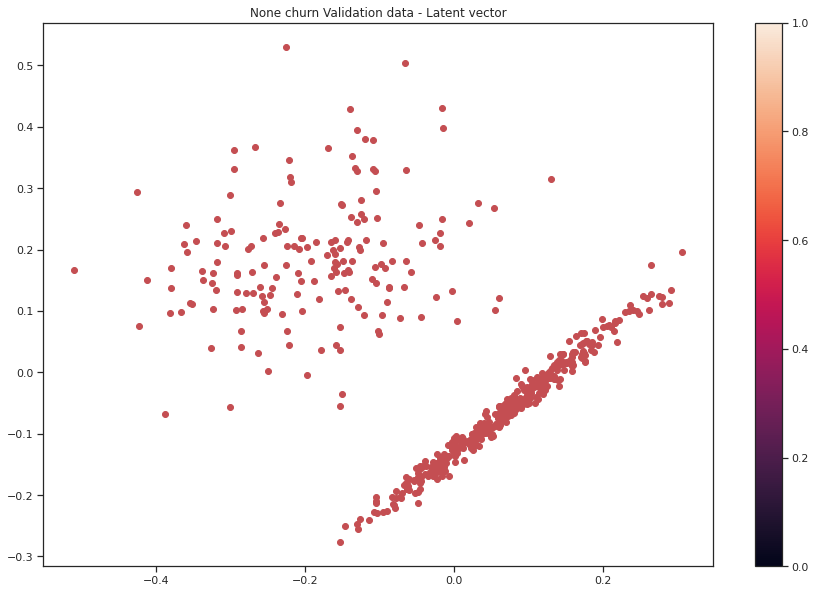

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(X_val_encoded_non_churn[0, :, 0],
            X_val_encoded_non_churn[0, :, 1],
            c='r', cmap='Paired')
plt.title("None churn Validation data - Latent vector")
plt.colorbar()

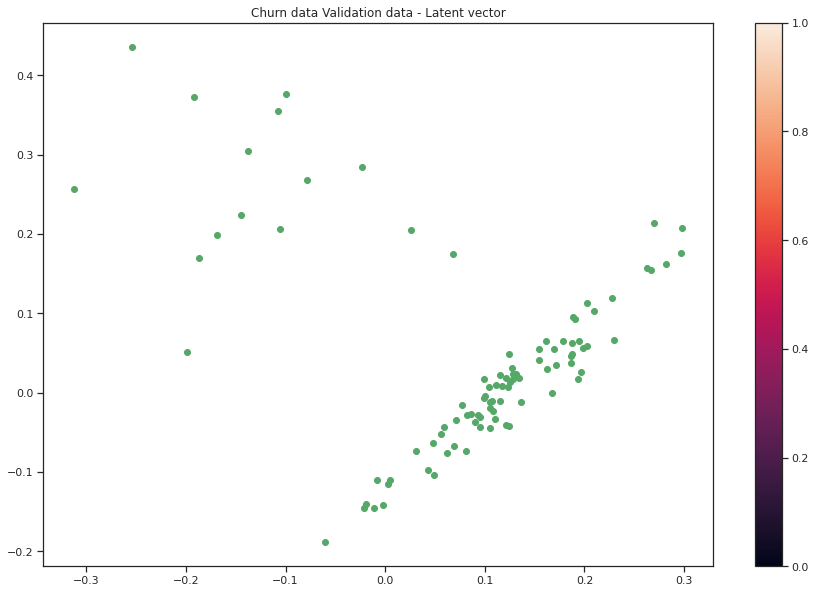

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(X_val_encoded_churn[0, :, 0],
            X_val_encoded_churn[0, :, 1],
            c='g', cmap='Paired')
plt.title("Churn data Validation data - Latent vector")
plt.colorbar()

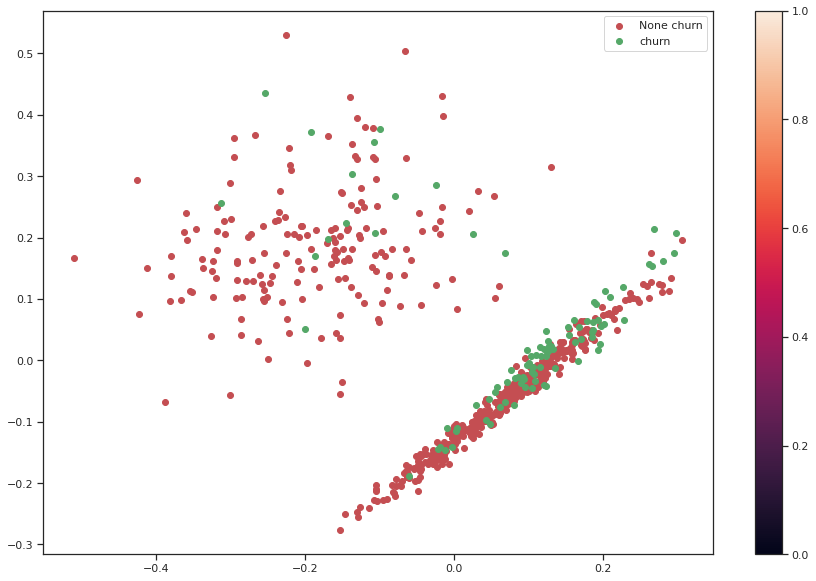

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(X_val_encoded_non_churn[0, :, 0],
            X_val_encoded_non_churn[0, :, 1],
            c='r', cmap='Paired', label='None churn')
plt.scatter(X_val_encoded_churn[0, :, 0],
            X_val_encoded_churn[0, :, 1],
            c='g', cmap='Paired', label='churn')
plt.legend()
plt.colorbar()

# Deep Learning

In [ ]:
import random
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, Flatten
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

random.seed(42)
np.random.seed(42)


In [ ]:
X_train, y_train = get_train_test(df)
X_val, y_val = get_val_data()

X train shape= (2666, 13)
y train shape= (2666,)
Churn in train rate: 0.145536384096024
 X val shape =  (667, 13)
 y val shape =  (667,)
Churn in train rate: 0.1424287856071964


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
X_train_resampled, y_train_resampled = resampling(X_train, y_train)
# X_train_resampled = X_train
# y_train_resampled = y_train

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train_resampled = X_train_resampled.reshape((-1, 
                                               X_train_resampled.shape[1],
                                               1))
X_train = X_train.reshape((-1, X_train.shape[1], 1))
# X_test = X_test.reshape((-1, X_test.shape[1], 1))
X_val = X_val.reshape((-1, X_val.shape[1], 1))

In [ ]:
earlyStop = EarlyStopping(monitor='loss', patience=10, verbose=1)

In [ ]:
from keras import regularizers

input_layer = Input(shape=(X_train.shape[1], 1))
x = Conv1D(filters=32, kernel_size=3,
           strides=1,
           activation='relu',
           padding='same',
           )(input_layer)
x = Conv1D(filters=32, kernel_size=3,
           strides=1,
           activation='relu',
           padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=32, kernel_size=2,
           strides=1,
           activation='relu',
           padding='same')(x)
x = Conv1D(filters=32, kernel_size=2,
           strides=1,
            activation='relu',
           padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu',
          activity_regularizer=regularizers.l2(1e-3))(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu',
          activity_regularizer=regularizers.l2(1e-3))(x)
x = Dropout(0.1)(x)
output_layer = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 13, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 32)             2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 32)             2080      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 32)             0     

In [ ]:
adam = Adam(lr=1e-3)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['acc'])

In [ ]:
model.fit(X_train_resampled,
          y_train_resampled,
          epochs=100,
          batch_size=256,
          verbose=1,
          validation_data=(X_val, y_val),
        #   validation_split=0.1,
          callbacks=[earlyStop],
          shuffle=True)

Epoch 1/100
18/18 [==============================] - 3s 21ms/step - loss: 0.6840 - acc: 0.5888 - val_loss: 0.6495 - val_acc: 0.6732
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.5832 - acc: 0.7279 - val_loss: 0.4798 - val_acc: 0.8096
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.4944 - acc: 0.7717 - val_loss: 0.4131 - val_acc: 0.8486
Epoch 4/100
18/18 [==============================] - 0s 15ms/step - loss: 0.4605 - acc: 0.7941 - val_loss: 0.5660 - val_acc: 0.7406
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.4317 - acc: 0.8117 - val_loss: 0.4395 - val_acc: 0.8141
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3946 - acc: 0.8301 - val_loss: 0.4075 - val_acc: 0.8351
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3901 - acc: 0.8279 - val_loss: 0.4165 - val_acc: 0.8351
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3524 -

In [ ]:
# y_test_predictions = model.predict(X_test)
y_val_predictions = model.predict(X_val)

In [ ]:
y_val_predictions[y_val_predictions>=0.5] = 1
y_val_predictions[y_val_predictions<=0.5] = 0

In [ ]:
print(metrics.classification_report(y_val,
                                    y_val_predictions))


              precision    recall  f1-score   support

           0       0.94      0.87      0.90       572
           1       0.46      0.65      0.54        95

    accuracy                           0.84       667
   macro avg       0.70      0.76      0.72       667
weighted avg       0.87      0.84      0.85       667



#Autoencoder

In [ ]:
import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

random.seed(42)
np.random.seed(42)

In [ ]:
X_train, y_train = get_train_test(df)
X_val, y_val = get_val_data()

X train shape= (2666, 13)
y train shape= (2666,)
Churn in train rate: 0.145536384096024
 X val shape =  (667, 13)
 y val shape =  (667,)
Churn in train rate: 0.1424287856071964


In [ ]:
y_train_non_churn = y_train[y_train==0]
y_train_churn = y_train[y_train==1]

In [ ]:
X_train_non_churn = X_train[y_train==0,:]
X_train_churn = X_train[y_train==1,:]

In [ ]:
# X_test_non_churn = X_test[y_test == 0, :]
# X_test_churn = X_test[y_test == 1, :]

X_val_non_churn = X_val[y_val == 0, :]
X_val_churn = X_val[y_val == 1, :]

# y_test_non_churn = y_test[y_test == 0]
# y_test_churn = y_test[y_test == 1]

y_val_non_churn = y_val[y_val == 0]
y_val_churn = y_val[y_val == 1]

In [ ]:
print("Train churn = ", X_train_churn.shape)
print("Train non churn = ", X_train_non_churn.shape)
# print("Test churn = ", X_test_churn.shape)
# print("Test none churn = ", X_test_non_churn.shape)
print("Val churn = ", X_val_churn.shape)
print("Val none churn = ", X_val_non_churn.shape)

Train churn =  (388, 13)
Train non churn =  (2278, 13)
Val churn =  (95, 13)
Val none churn =  (572, 13)


In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X_train_non_churn)
X_train_non_churn = scaler.transform(X_train_non_churn)
X_train_churn = scaler.transform(X_train_churn)

# X_test_non_churn = scaler.transform(X_test_non_churn)
# X_test_churn = scaler.transform(X_test_churn)

X_val_non_churn = scaler.transform(X_val_non_churn)
X_val_churn = scaler.transform(X_val_churn)

In [ ]:
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
print("Train churn = ", X_train_churn.shape)
print("Train non churn = ", X_train_non_churn.shape)
# print("Test churn = ", X_test_churn.shape)
# print("Test none churn = ", X_test_non_churn.shape)
print("Val churn = ", X_val_churn.shape)
print("Val none churn = ", X_val_non_churn.shape)

Train churn =  (388, 13)
Train non churn =  (2278, 13)
Val churn =  (95, 13)
Val none churn =  (572, 13)


In [ ]:
X_train_reshape = X_train_non_churn
y_train_reshape = y_train_non_churn

original_dim = X_train_reshape.shape[1]
encoding_dim = 512
hidden_dim1 = int(encoding_dim/4) 
hidden_dim2 = int(encoding_dim/32) 

input_layer = Input(shape=(original_dim, ))
encoder = Dense(encoding_dim, activation="relu",
            activity_regularizer=regularizers.l1(1e-3)
            )(input_layer)
encoder = Dense(hidden_dim1, activation="relu",
            activity_regularizer=regularizers.l1(1e-3)
                )(encoder)
encoder = Dense(hidden_dim2, activation="relu",
            activity_regularizer=regularizers.l1(1e-3)
                )(encoder)
decoder = Dense(hidden_dim2, activation="relu",
            activity_regularizer=regularizers.l1(1e-3)
                )(encoder)
decoder = Dense(hidden_dim1, activation="relu",
            activity_regularizer=regularizers.l1(1e-3)
                )(decoder)
decoder = Dense(encoding_dim, activation="relu",
            activity_regularizer=regularizers.l1(1e-3)
                )(decoder)
decoder = Dense(original_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               7168      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_12 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_15 (Dense)             (None, 512)               6604

In [ ]:
autoencoder.compile(metrics=['mse'],
                    loss='mse',
                    optimizer='adam')

In [ ]:
history = autoencoder.fit(X_train_non_churn,
                          X_train_non_churn,
                          epochs=150,
                          shuffle=True,
                          batch_size=128,
                          validation_data=(X_val_non_churn,
                                           X_val_non_churn))

Epoch 1/150
18/18 [==============================] - 1s 16ms/step - loss: 0.8650 - mse: 0.8149 - val_loss: 0.7553 - val_mse: 0.6826
Epoch 2/150
18/18 [==============================] - 0s 6ms/step - loss: 0.6792 - mse: 0.5937 - val_loss: 0.5295 - val_mse: 0.4186
Epoch 3/150
18/18 [==============================] - 0s 5ms/step - loss: 0.4847 - mse: 0.3712 - val_loss: 0.3984 - val_mse: 0.2822
Epoch 4/150
18/18 [==============================] - 0s 6ms/step - loss: 0.3676 - mse: 0.2515 - val_loss: 0.3019 - val_mse: 0.1846
Epoch 5/150
18/18 [==============================] - 0s 5ms/step - loss: 0.2772 - mse: 0.1621 - val_loss: 0.2268 - val_mse: 0.1136
Epoch 6/150
18/18 [==============================] - 0s 5ms/step - loss: 0.2113 - mse: 0.0986 - val_loss: 0.1710 - val_mse: 0.0618
Epoch 7/150
18/18 [==============================] - 0s 6ms/step - loss: 0.1485 - mse: 0.0410 - val_loss: 0.1268 - val_mse: 0.0211
Epoch 8/150
18/18 [==============================] - 0s 6ms/step - loss: 0.1187 - 

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

### Validation data

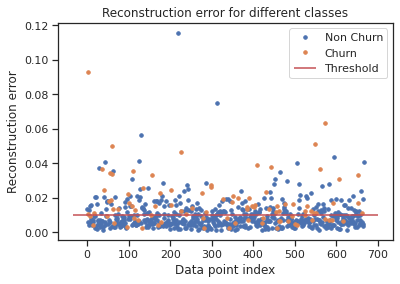

In [ ]:
val_x_predictions = autoencoder.predict(X_val)
mse = np.mean(np.power(X_val - val_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_val})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.01
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Churn" if name == 1 else "Non Churn")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

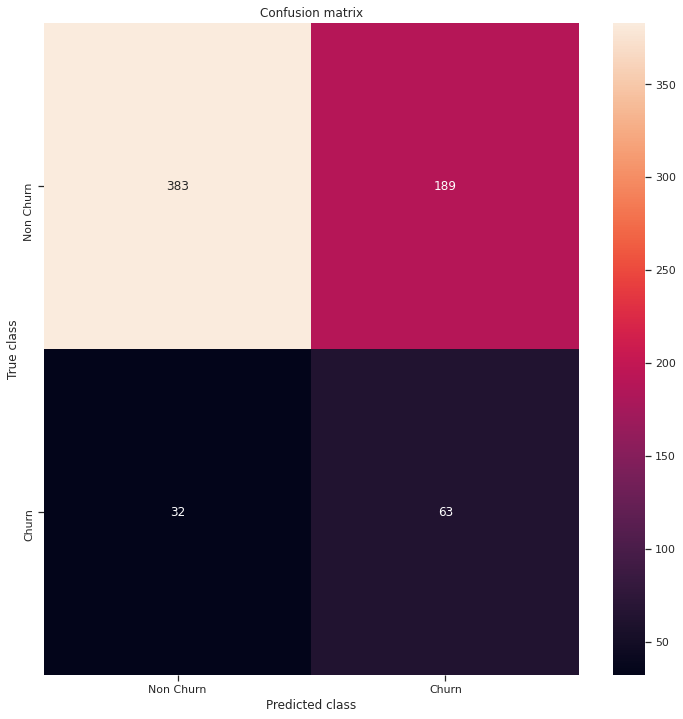

In [ ]:
LABELS = ["Non Churn","Churn"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
print(classification_report(error_df_test.True_class, pred_y))

              precision    recall  f1-score   support

           0       0.92      0.67      0.78       572
           1       0.25      0.66      0.36        95

    accuracy                           0.67       667
   macro avg       0.59      0.67      0.57       667
weighted avg       0.83      0.67      0.72       667



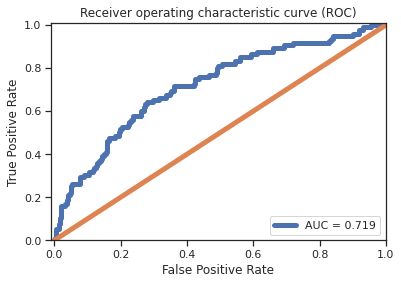

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df_test.True_class, 
                                                      error_df_test.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, 
         label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()